In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import precision_score, recall_score, f1_score

from PIL import Image
import io, pickle
from tqdm import tqdm, trange
import numpy as np
import random

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('images/images.pickle', 'rb') as f:
    img_data = pickle.load(f)
class CustomDataset(Dataset):
    def __init__(self, img_data, txt_file, transform=None):
        self.data = img_data
        with open(txt_file, 'r') as f:
            self.labels = f.readlines()
        self.transform = transform
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        img_path, label = self.labels[idx].strip().split()
        img_path = img_path.split('/')
        img = self.data[img_path[1]][img_path[2]]
        img = Image.open(io.BytesIO(img)).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(int(label))
        open_channels = torch.tensor([1] * 3)
        return img, label, open_channels

class CustomDataset_Diff_CH(Dataset):
    def __init__(self, img_data, txt_file, transform=None):
        self.data = img_data
        with open(txt_file, 'r') as f:
            self.labels = f.readlines()
        self.transform = transform
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        img_path, label = self.labels[idx].strip().split()
        img_path = img_path.split('/')
        img = self.data[img_path[1]][img_path[2]]
        img = Image.open(io.BytesIO(img)).convert('RGB')
        if self.transform:
            img = self.transform(img)
        # 定義數字集合
        numbers = [0, 1, 2]
        open_channels = [1] * 3
        # 隨機挑選0到2個數字
        selected_numbers = random.sample(numbers, random.randint(0, 2))
        for i in selected_numbers:
            img[i, :, :] = 0
            open_channels[i] = 0
        label = torch.tensor(int(label))
        open_channels = torch.tensor(open_channels)
        return img, label, open_channels

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset_train = CustomDataset(img_data=img_data, txt_file='images/train.txt', transform=transform)
dataset_val = CustomDataset_Diff_CH(img_data=img_data, txt_file='images/val.txt', transform=transform)
dataset_test = CustomDataset_Diff_CH(img_data=img_data, txt_file='images/test.txt', transform=transform)


data_loader_train = DataLoader(dataset_train, batch_size=32, shuffle=True, )
data_loader_val = DataLoader(dataset_val, batch_size=32, shuffle=False)
data_loader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)


In [5]:
class CustomConv(nn.Module):
    def __init__(self, out_channels, img_size, kernel_size):
        super(CustomConv, self).__init__()

        self.linear_R = nn.Linear(img_size*img_size, 1)
        self.linear_G = nn.Linear(img_size*img_size, 1)
        self.linear_B = nn.Linear(img_size*img_size, 1)

        self.conv = nn.Conv2d(in_channels=3, out_channels=out_channels, kernel_size=kernel_size, padding=kernel_size//2)
        
    def forward(self, x, open_channels):
        batch_size, channels, height, width = x.size()
        # Flatten each channel
        x_flattened = x.view(batch_size, channels, -1)  # Shape: (batch_size, channels, height*width)
        weight_R = self.linear_R(x_flattened[:, 0, :])
        weight_G = self.linear_G(x_flattened[:, 1, :])
        weight_B = self.linear_B(x_flattened[:, 2, :])
        kernel_weight = torch.stack([weight_R, weight_G, weight_B]).permute(1, 0, 2) 
        kernel_weight = kernel_weight.masked_fill(open_channels.unsqueeze(-1) == 0, float('-inf'))
        kernel_weight = F.softmax(kernel_weight, dim=1)
        # print(kernel_weight)
        out = self.conv(x*kernel_weight.unsqueeze(-1))
        return out

# 示例使用
input_tensor = torch.randn(3, 3, 2, 2)  # batch_size=1, channels=3, height=32, width=32
model = CustomConv(out_channels=6, img_size=2, kernel_size=3)
output = model(input_tensor, torch.tensor([[1, 0, 0], [1, 0, 1], [1, 1, 1]]))
print(output.shape)  # 输出的形状

torch.Size([3, 6, 2, 2])


In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class CNNModel_Diff_CH(nn.Module):

    def __init__(self, num_classes=50):
        super(CNNModel_Diff_CH, self).__init__()
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        ########## My Custom Conv module
        self.CustomConv1 = CustomConv(out_channels=64, img_size=224, kernel_size=3)
        ##########
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.fc1 = nn.Linear(512*14*14, 4096)
        self.fc2 = nn.Linear(4096, 512)
        self.fc3 = nn.Linear(512, num_classes)
        self.activation = nn.ReLU()
        self.flatten = nn.Flatten()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout25 = nn.Dropout(0.25)
        self.dropout50 = nn.Dropout(0.5)
    def forward(self, x, open_channels):
        x = self.pool(self.activation(self.bn1(self.CustomConv1(x, open_channels))))
        x = self.pool(self.activation(self.bn2(self.conv2(x))))
        x = self.pool(self.activation(self.bn3(self.conv3(x))))
        x = self.pool(self.activation(self.bn4(self.conv4(x))))
        x = self.dropout25(self.flatten(x))
        x = self.dropout50(self.activation(self.fc1(x)))
        x = self.dropout50(self.activation(self.fc2(x)))
        # x = self.flatten(x)
        # x = self.gelu(self.fc1(x))
        # x = self.gelu(self.fc2(x))
        x = self.fc3(x)
        return x


for lr in [1e-4]:
    model = CNNModel_Diff_CH(num_classes=50).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    num_epochs = 50
    save_path = 'record/Q1_diff_ch_reweighted'
    model_path = f'{save_path}/model_weight/model_weight_lr{lr}_bn_dropout.pth'
    best_val_loss = float('inf')
    best_model = None
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        pbar = tqdm(data_loader_train, colour='green', total=len(data_loader_train))
        for images, labels, open_channels in pbar:
            images, labels, open_channels = images.to(device), labels.to(device), open_channels.to(device)
            optimizer.zero_grad()
            outputs = model(images, open_channels)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()*len(labels)
            running_acc += (outputs.argmax(dim=1) == labels).float().sum().item()
            pbar.set_description(f'Train Iter: {epoch+1:03}/{num_epochs:03}  Loss: {loss:3.4f}')
            pbar.update()
        running_loss_avg = running_loss / len(dataset_train)
        running_acc_avg = running_acc / len(dataset_train)
        train_loss.append(running_loss_avg)
        train_acc.append(running_acc_avg)
        print(f"Epoch {epoch+1}, Loss: {running_loss_avg}, Accuracy: {running_acc_avg}")

        model.eval()
        with torch.no_grad():
            class_counts = [0] * 50
            running_loss = 0.0
            running_acc = 0.0
            pbar = tqdm(data_loader_val, colour='red', total=len(data_loader_val))
            for images, labels, open_channels in pbar:
                images, labels, open_channels = images.to(device), labels.to(device), open_channels.to(device)
                outputs = model(images, open_channels)
                predictions = outputs.argmax(dim=1)
                loss = criterion(outputs, labels)
                running_loss += loss.item()*len(labels)
                running_acc += (predictions == labels).float().sum().item()
                pbar.set_description(f'Valid Iter: {epoch+1:03}/{num_epochs:03}  Loss: {loss:3.4f}')
                pbar.update()

                for pred_label in predictions:
                    class_counts[pred_label] += 1

            running_loss_avg = running_loss / len(dataset_val)
            running_acc_avg = running_acc / len(dataset_val)
            val_loss.append(running_loss_avg)
            val_acc.append(running_acc_avg)
            print(f"Validation Loss: {running_loss_avg}, Accuracy: {running_acc_avg}")
            print(f"Class Counts: {class_counts}")
            if running_loss_avg < best_val_loss:
                best_val_loss = running_loss
                best_model = model
                torch.save(model.state_dict(), model_path)
        print("======================================")
    print("Finished Training")


    model.eval()
    with torch.no_grad():
        class_counts = [0] * 50
        running_loss = 0.0
        running_acc = 0.0
        predictions = []
        true_labels = []
        pbar = tqdm(data_loader_test, colour='red', total=len(data_loader_test))
        for images, labels, open_channels in pbar:
            images, labels, open_channels = images.to(device), labels.to(device), open_channels.to(device)
            outputs = model(images, open_channels)

            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            running_loss += loss.item()*len(labels)
            running_acc += (outputs.argmax(dim=1) == labels).float().sum().item()
            pbar.set_description(f'Test Iter: {epoch+1:03}/{num_epochs:03}  Loss: {loss:3.4f}')
            pbar.update()

        for pred_label in predictions:
            class_counts[pred_label] += 1
        
        precision = precision_score(true_labels, predictions, average='weighted')
        recall = recall_score(true_labels, predictions, average='weighted')
        f1 = f1_score(true_labels, predictions, average='weighted')
        print(f"Test Loss: {running_loss/len(dataset_test)}, Accuracy: {running_acc/len(dataset_test)}")
        print(f"Precision: {precision}, Recall: {recall}, F1: {f1}")
        print(f"Class Counts: {class_counts}")
    print("Finished Testing")

    train_record = {"train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc}
    test_record = {"true_labels": true_labels, "predictions": predictions, "precision": precision, "recall": recall, "f1": f1, "class_counts": class_counts}

    with open(f'{save_path}/train_record/train_record_lr{lr}_bn_dropout.pkl', 'wb') as f:
        pickle.dump(train_record, f)
    with open(f'{save_path}/test_record/test_record_lr{lr}_bn_dropout.pkl', 'wb') as f:
        pickle.dump(test_record, f)


Train Iter: 001/050  Loss: 3.8600: 100%|██████████| 1979/1979 [03:39<00:00,  9.01it/s]


Epoch 1, Loss: 3.9229684808816168, Accuracy: 0.02569285432293723


Valid Iter: 001/050  Loss: 3.4086: 100%|██████████| 15/15 [00:00<00:00, 23.81it/s]


Validation Loss: 3.881356004079183, Accuracy: 0.03777777777777778
Class Counts: [26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 0, 339, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 3, 0, 1, 1, 5, 0, 21, 0, 0, 24]


Train Iter: 002/050  Loss: 3.6489: 100%|██████████| 1979/1979 [03:41<00:00,  8.93it/s]


Epoch 2, Loss: 3.816381158730845, Accuracy: 0.04464271614686143


Valid Iter: 002/050  Loss: 2.9962: 100%|██████████| 15/15 [00:00<00:00, 24.50it/s]


Validation Loss: 3.5936386818355985, Accuracy: 0.06888888888888889
Class Counts: [1, 14, 43, 0, 13, 0, 0, 0, 0, 0, 2, 0, 0, 0, 16, 8, 0, 0, 0, 3, 5, 0, 0, 54, 0, 3, 0, 0, 10, 0, 0, 3, 63, 0, 3, 1, 7, 65, 0, 3, 0, 53, 2, 25, 6, 4, 5, 0, 17, 21]


Train Iter: 003/050  Loss: 3.4295: 100%|██████████| 1979/1979 [03:39<00:00,  9.01it/s]


Epoch 3, Loss: 3.4828911053837874, Accuracy: 0.09051717331227793


Valid Iter: 003/050  Loss: 3.1149: 100%|██████████| 15/15 [00:00<00:00, 23.43it/s]


Validation Loss: 3.242626945707533, Accuracy: 0.10222222222222223
Class Counts: [8, 10, 25, 21, 18, 7, 13, 4, 0, 0, 7, 0, 0, 0, 9, 20, 0, 0, 26, 5, 6, 4, 4, 0, 0, 9, 0, 4, 18, 5, 3, 1, 3, 4, 13, 32, 14, 10, 2, 20, 14, 30, 18, 1, 4, 14, 11, 0, 20, 13]


Train Iter: 004/050  Loss: 2.7422: 100%|██████████| 1979/1979 [03:39<00:00,  9.02it/s]


Epoch 4, Loss: 3.2567782604821436, Accuracy: 0.12595341492301618


Valid Iter: 004/050  Loss: 2.3188: 100%|██████████| 15/15 [00:00<00:00, 24.20it/s]


Validation Loss: 3.0550531991322836, Accuracy: 0.14888888888888888
Class Counts: [6, 6, 26, 0, 14, 4, 5, 4, 3, 0, 0, 0, 0, 0, 28, 20, 19, 0, 14, 6, 3, 2, 15, 13, 4, 8, 3, 12, 14, 12, 1, 5, 10, 17, 13, 2, 4, 16, 11, 18, 6, 19, 17, 10, 6, 15, 12, 4, 8, 15]


Train Iter: 005/050  Loss: 2.8225: 100%|██████████| 1979/1979 [03:39<00:00,  9.00it/s]


Epoch 5, Loss: 3.1113731611608, Accuracy: 0.15445716541650217


Valid Iter: 005/050  Loss: 1.2819: 100%|██████████| 15/15 [00:00<00:00, 24.42it/s]


Validation Loss: 2.909164120356242, Accuracy: 0.18222222222222223
Class Counts: [19, 3, 22, 12, 22, 17, 4, 5, 5, 0, 0, 0, 0, 2, 14, 5, 5, 10, 12, 10, 8, 0, 7, 9, 5, 15, 0, 32, 19, 4, 0, 3, 8, 23, 12, 10, 4, 10, 7, 12, 5, 8, 11, 6, 7, 8, 14, 4, 13, 19]


Train Iter: 006/050  Loss: 2.8528: 100%|██████████| 1979/1979 [03:40<00:00,  8.98it/s]


Epoch 6, Loss: 2.979221322752015, Accuracy: 0.1814291354125543


Valid Iter: 006/050  Loss: 1.4304: 100%|██████████| 15/15 [00:00<00:00, 23.13it/s]


Validation Loss: 2.8063908354441325, Accuracy: 0.20444444444444446
Class Counts: [12, 15, 9, 3, 15, 23, 3, 7, 8, 0, 0, 0, 1, 2, 11, 16, 8, 5, 7, 6, 5, 2, 9, 7, 8, 9, 4, 35, 8, 8, 1, 4, 12, 13, 8, 8, 8, 13, 5, 21, 13, 14, 6, 16, 5, 7, 10, 2, 24, 14]


Train Iter: 007/050  Loss: 2.7224: 100%|██████████| 1979/1979 [03:39<00:00,  9.01it/s]


Epoch 7, Loss: 2.855581528331939, Accuracy: 0.20878010264508487


Valid Iter: 007/050  Loss: 1.5713: 100%|██████████| 15/15 [00:00<00:00, 24.28it/s]


Validation Loss: 2.7391886854171754, Accuracy: 0.22444444444444445
Class Counts: [10, 8, 11, 6, 7, 23, 10, 11, 14, 0, 1, 1, 2, 0, 7, 11, 9, 8, 12, 15, 9, 5, 8, 4, 8, 10, 1, 17, 10, 6, 3, 7, 11, 10, 4, 10, 11, 5, 12, 19, 21, 23, 10, 10, 6, 9, 12, 4, 9, 10]


Train Iter: 008/050  Loss: 2.6555: 100%|██████████| 1979/1979 [03:40<00:00,  8.99it/s]


Epoch 8, Loss: 2.739590357021056, Accuracy: 0.23638373470193447


Valid Iter: 008/050  Loss: 1.1383: 100%|██████████| 15/15 [00:00<00:00, 24.49it/s]


Validation Loss: 2.743421392440796, Accuracy: 0.19333333333333333
Class Counts: [4, 3, 6, 7, 11, 9, 3, 7, 0, 1, 0, 1, 1, 1, 18, 13, 7, 5, 4, 15, 14, 4, 20, 14, 16, 14, 4, 19, 6, 13, 2, 16, 16, 8, 16, 11, 6, 11, 7, 14, 10, 5, 19, 4, 6, 7, 13, 6, 17, 16]


Train Iter: 009/050  Loss: 2.5700: 100%|██████████| 1979/1979 [03:40<00:00,  8.98it/s]


Epoch 9, Loss: 2.63861078813525, Accuracy: 0.25748124753257007


Valid Iter: 009/050  Loss: 1.4387: 100%|██████████| 15/15 [00:00<00:00, 23.99it/s]


Validation Loss: 2.6172431092792086, Accuracy: 0.25555555555555554
Class Counts: [8, 18, 18, 13, 12, 17, 8, 13, 15, 1, 2, 2, 4, 2, 15, 18, 9, 6, 2, 6, 6, 3, 10, 3, 8, 7, 2, 19, 12, 0, 4, 4, 3, 15, 4, 25, 4, 17, 10, 7, 18, 20, 2, 6, 9, 17, 6, 2, 10, 8]


Train Iter: 010/050  Loss: 2.5002: 100%|██████████| 1979/1979 [03:40<00:00,  8.98it/s]


Epoch 10, Loss: 2.542593728873836, Accuracy: 0.2792104224240032


Valid Iter: 010/050  Loss: 0.6932: 100%|██████████| 15/15 [00:00<00:00, 23.59it/s]


Validation Loss: 2.5087454472647774, Accuracy: 0.28888888888888886
Class Counts: [8, 17, 11, 17, 8, 26, 7, 12, 7, 0, 2, 1, 2, 1, 9, 10, 2, 11, 16, 11, 12, 4, 6, 6, 3, 17, 2, 20, 3, 1, 2, 13, 11, 11, 4, 12, 8, 12, 3, 20, 10, 11, 15, 6, 13, 9, 13, 3, 8, 14]


Train Iter: 011/050  Loss: 2.4706: 100%|██████████| 1979/1979 [03:41<00:00,  8.95it/s]


Epoch 11, Loss: 2.4400186727548654, Accuracy: 0.30231346229767075


Valid Iter: 011/050  Loss: 0.6513: 100%|██████████| 15/15 [00:00<00:00, 24.61it/s]


Validation Loss: 2.454562051296234, Accuracy: 0.2911111111111111
Class Counts: [14, 11, 14, 19, 8, 18, 9, 11, 5, 6, 2, 4, 7, 1, 11, 17, 7, 1, 7, 9, 6, 7, 12, 3, 7, 11, 2, 13, 15, 3, 1, 6, 16, 7, 5, 9, 12, 6, 3, 20, 11, 10, 12, 6, 10, 9, 12, 3, 14, 18]


Train Iter: 012/050  Loss: 1.9997: 100%|██████████| 1979/1979 [03:41<00:00,  8.94it/s]


Epoch 12, Loss: 2.347805146570503, Accuracy: 0.3226845637583893


Valid Iter: 012/050  Loss: 0.8898: 100%|██████████| 15/15 [00:00<00:00, 24.14it/s]


Validation Loss: 2.3138616728782653, Accuracy: 0.33555555555555555
Class Counts: [9, 14, 8, 7, 10, 19, 5, 9, 10, 3, 2, 1, 6, 6, 11, 12, 8, 9, 14, 6, 10, 1, 16, 8, 12, 6, 2, 12, 14, 6, 5, 10, 11, 5, 9, 4, 7, 10, 5, 11, 19, 20, 9, 15, 9, 9, 15, 4, 8, 9]


Train Iter: 013/050  Loss: 2.6116: 100%|██████████| 1979/1979 [03:41<00:00,  8.94it/s]


Epoch 13, Loss: 2.258438149244005, Accuracy: 0.34321358073430713


Valid Iter: 013/050  Loss: 0.8477: 100%|██████████| 15/15 [00:00<00:00, 24.09it/s]


Validation Loss: 2.3050827892621357, Accuracy: 0.31777777777777777
Class Counts: [15, 17, 12, 10, 17, 6, 7, 15, 5, 5, 4, 1, 7, 1, 15, 8, 7, 12, 5, 4, 7, 2, 9, 9, 5, 12, 2, 19, 6, 9, 2, 14, 13, 19, 6, 12, 6, 13, 2, 11, 13, 10, 12, 11, 12, 5, 9, 5, 11, 11]


Train Iter: 014/050  Loss: 2.2695: 100%|██████████| 1979/1979 [03:42<00:00,  8.91it/s]


Epoch 14, Loss: 2.167705966566939, Accuracy: 0.3651954204500592


Valid Iter: 014/050  Loss: 0.4624: 100%|██████████| 15/15 [00:00<00:00, 24.14it/s]


Validation Loss: 2.3243343753284877, Accuracy: 0.33555555555555555
Class Counts: [8, 13, 20, 16, 9, 11, 6, 12, 5, 2, 2, 6, 8, 5, 16, 6, 8, 7, 16, 6, 5, 9, 9, 12, 9, 13, 1, 9, 13, 8, 10, 12, 10, 6, 4, 8, 7, 6, 2, 12, 21, 13, 3, 6, 16, 10, 11, 4, 11, 8]


Train Iter: 015/050  Loss: 2.2957: 100%|██████████| 1979/1979 [03:41<00:00,  8.93it/s]


Epoch 15, Loss: 2.0791678774540387, Accuracy: 0.38701934465061194


Valid Iter: 015/050  Loss: 0.2629: 100%|██████████| 15/15 [00:00<00:00, 24.35it/s]


Validation Loss: 2.259856600496504, Accuracy: 0.3288888888888889
Class Counts: [11, 9, 11, 17, 8, 15, 7, 12, 10, 4, 4, 1, 6, 8, 16, 7, 12, 6, 11, 8, 15, 5, 5, 7, 4, 7, 3, 16, 9, 11, 2, 4, 14, 9, 7, 13, 9, 12, 7, 10, 13, 11, 7, 11, 10, 12, 10, 6, 8, 10]


Train Iter: 016/050  Loss: 2.4673: 100%|██████████| 1979/1979 [03:41<00:00,  8.93it/s]


Epoch 16, Loss: 1.9942733377681812, Accuracy: 0.40457954994078166


Valid Iter: 016/050  Loss: 0.2014: 100%|██████████| 15/15 [00:00<00:00, 23.07it/s]


Validation Loss: 2.22018126156595, Accuracy: 0.3466666666666667
Class Counts: [6, 11, 2, 9, 13, 9, 9, 6, 6, 3, 8, 5, 5, 12, 13, 9, 15, 8, 8, 9, 11, 2, 10, 14, 5, 21, 3, 17, 4, 7, 8, 7, 21, 8, 6, 6, 7, 9, 7, 15, 10, 8, 10, 13, 11, 8, 8, 5, 13, 10]


Train Iter: 017/050  Loss: 1.5044: 100%|██████████| 1979/1979 [03:40<00:00,  8.97it/s]


Epoch 17, Loss: 1.9018014499692169, Accuracy: 0.42935649427556255


Valid Iter: 017/050  Loss: 1.1083: 100%|██████████| 15/15 [00:00<00:00, 24.21it/s]


Validation Loss: 2.200600558386909, Accuracy: 0.35555555555555557
Class Counts: [14, 17, 17, 14, 6, 17, 11, 16, 16, 3, 1, 2, 6, 4, 12, 19, 12, 5, 8, 9, 7, 3, 5, 8, 4, 8, 12, 12, 9, 7, 4, 4, 14, 7, 8, 8, 5, 9, 4, 11, 9, 6, 7, 11, 11, 10, 7, 4, 17, 10]


Train Iter: 018/050  Loss: 1.8106: 100%|██████████| 1979/1979 [03:40<00:00,  8.97it/s]


Epoch 18, Loss: 1.8188291755948103, Accuracy: 0.4487801026450849


Valid Iter: 018/050  Loss: 0.9941: 100%|██████████| 15/15 [00:00<00:00, 24.33it/s]


Validation Loss: 2.2280701557795206, Accuracy: 0.35333333333333333
Class Counts: [10, 14, 2, 13, 13, 11, 7, 7, 11, 4, 8, 3, 7, 12, 19, 9, 14, 2, 13, 8, 13, 2, 19, 4, 4, 14, 6, 15, 2, 9, 7, 9, 14, 9, 5, 16, 5, 8, 5, 12, 6, 6, 4, 15, 10, 12, 9, 7, 10, 6]


Train Iter: 019/050  Loss: 1.7344: 100%|██████████| 1979/1979 [03:39<00:00,  9.04it/s]


Epoch 19, Loss: 1.7330697775225934, Accuracy: 0.4693722858270825


Valid Iter: 019/050  Loss: 0.6625: 100%|██████████| 15/15 [00:00<00:00, 24.58it/s]


Validation Loss: 2.16029360877143, Accuracy: 0.3977777777777778
Class Counts: [5, 17, 6, 9, 9, 10, 8, 13, 6, 7, 7, 2, 4, 7, 11, 10, 8, 7, 13, 7, 11, 3, 8, 11, 3, 11, 3, 14, 5, 13, 7, 10, 14, 10, 5, 15, 8, 13, 12, 12, 14, 8, 8, 11, 12, 12, 7, 5, 12, 7]


Train Iter: 020/050  Loss: 1.5061: 100%|██████████| 1979/1979 [03:40<00:00,  8.98it/s]


Epoch 20, Loss: 1.6507526885197183, Accuracy: 0.4898539281484406


Valid Iter: 020/050  Loss: 0.3452: 100%|██████████| 15/15 [00:00<00:00, 24.04it/s]


Validation Loss: 2.2097916796472337, Accuracy: 0.35555555555555557
Class Counts: [10, 13, 9, 12, 6, 10, 9, 23, 9, 10, 4, 2, 5, 6, 10, 7, 11, 10, 18, 10, 5, 7, 12, 11, 6, 11, 5, 10, 6, 5, 7, 8, 14, 8, 8, 7, 8, 4, 4, 11, 10, 9, 8, 12, 16, 10, 10, 6, 11, 7]


Train Iter: 021/050  Loss: 1.9203: 100%|██████████| 1979/1979 [03:39<00:00,  9.01it/s]


Epoch 21, Loss: 1.5689158381579942, Accuracy: 0.5114409790761942


Valid Iter: 021/050  Loss: 0.1046: 100%|██████████| 15/15 [00:00<00:00, 24.24it/s]


Validation Loss: 2.1689327725105816, Accuracy: 0.37777777777777777
Class Counts: [10, 17, 8, 8, 11, 7, 10, 7, 9, 10, 8, 2, 8, 7, 12, 9, 10, 8, 12, 14, 6, 6, 6, 6, 4, 12, 13, 11, 6, 7, 8, 14, 17, 7, 3, 11, 5, 9, 6, 11, 13, 4, 11, 9, 12, 12, 9, 7, 10, 8]


Train Iter: 022/050  Loss: 1.3427: 100%|██████████| 1979/1979 [03:41<00:00,  8.92it/s]


Epoch 22, Loss: 1.502080132056732, Accuracy: 0.5296802210817213


Valid Iter: 022/050  Loss: 0.5626: 100%|██████████| 15/15 [00:00<00:00, 19.54it/s]


Validation Loss: 2.124143567085266, Accuracy: 0.37555555555555553
Class Counts: [9, 11, 6, 11, 9, 7, 8, 15, 4, 7, 4, 2, 7, 10, 15, 7, 11, 7, 6, 8, 14, 5, 9, 6, 2, 12, 8, 11, 4, 8, 12, 11, 19, 6, 4, 10, 8, 10, 6, 12, 13, 7, 14, 18, 8, 9, 10, 7, 12, 11]


Train Iter: 023/050  Loss: 1.8637: 100%|██████████| 1979/1979 [03:41<00:00,  8.94it/s]


Epoch 23, Loss: 1.4155961848133598, Accuracy: 0.5518673509672325


Valid Iter: 023/050  Loss: 0.3486: 100%|██████████| 15/15 [00:00<00:00, 24.34it/s]


Validation Loss: 2.168787738217248, Accuracy: 0.4
Class Counts: [12, 6, 7, 12, 12, 11, 9, 13, 10, 8, 5, 5, 4, 9, 17, 13, 16, 9, 16, 7, 13, 5, 4, 9, 4, 6, 3, 8, 3, 11, 3, 8, 12, 10, 5, 15, 7, 11, 8, 11, 16, 10, 4, 7, 15, 11, 9, 2, 8, 11]


Train Iter: 024/050  Loss: 2.0040: 100%|██████████| 1979/1979 [03:39<00:00,  9.00it/s]


Epoch 24, Loss: 1.3396687884844671, Accuracy: 0.5745913936044217


Valid Iter: 024/050  Loss: 0.0513: 100%|██████████| 15/15 [00:00<00:00, 24.45it/s]


Validation Loss: 2.163941641814179, Accuracy: 0.4111111111111111
Class Counts: [8, 6, 6, 12, 12, 9, 6, 4, 6, 8, 4, 8, 10, 6, 17, 5, 11, 11, 16, 6, 8, 7, 1, 5, 3, 13, 6, 10, 15, 12, 7, 15, 12, 13, 7, 11, 6, 6, 11, 6, 12, 12, 10, 15, 10, 7, 12, 5, 14, 8]


Train Iter: 025/050  Loss: 1.2310: 100%|██████████| 1979/1979 [03:40<00:00,  8.97it/s]


Epoch 25, Loss: 1.2766511571732049, Accuracy: 0.5915357283853139


Valid Iter: 025/050  Loss: 0.2265: 100%|██████████| 15/15 [00:00<00:00, 24.70it/s]


Validation Loss: 2.2001784789562224, Accuracy: 0.37777777777777777
Class Counts: [10, 12, 10, 8, 9, 6, 3, 12, 11, 8, 3, 4, 7, 4, 20, 9, 5, 6, 19, 8, 13, 7, 7, 9, 2, 9, 6, 10, 5, 12, 7, 9, 13, 13, 5, 16, 10, 14, 9, 11, 11, 9, 2, 13, 7, 11, 11, 5, 12, 8]


Train Iter: 026/050  Loss: 0.9778: 100%|██████████| 1979/1979 [03:39<00:00,  9.00it/s]


Epoch 26, Loss: 1.2019706271742343, Accuracy: 0.6139439399921042


Valid Iter: 026/050  Loss: 0.1460: 100%|██████████| 15/15 [00:00<00:00, 23.92it/s]


Validation Loss: 2.2454697517553965, Accuracy: 0.3933333333333333
Class Counts: [8, 7, 8, 8, 10, 11, 5, 3, 11, 5, 8, 2, 5, 9, 13, 12, 7, 9, 14, 6, 10, 3, 7, 11, 3, 16, 7, 13, 6, 15, 7, 9, 15, 8, 7, 12, 9, 10, 12, 17, 9, 10, 3, 12, 8, 10, 11, 8, 13, 8]


Train Iter: 027/050  Loss: 1.6619: 100%|██████████| 1979/1979 [03:40<00:00,  8.98it/s]


Epoch 27, Loss: 1.135478089570152, Accuracy: 0.632767469403869


Valid Iter: 027/050  Loss: 0.0736: 100%|██████████| 15/15 [00:00<00:00, 24.12it/s]


Validation Loss: 2.235745646258195, Accuracy: 0.3888888888888889
Class Counts: [12, 8, 9, 7, 7, 15, 4, 11, 11, 14, 7, 6, 5, 7, 13, 8, 10, 13, 16, 7, 4, 9, 5, 5, 0, 12, 4, 14, 8, 8, 6, 16, 13, 7, 7, 13, 7, 10, 5, 6, 16, 10, 7, 10, 10, 10, 10, 7, 12, 9]


Train Iter: 028/050  Loss: 0.7289: 100%|██████████| 1979/1979 [03:41<00:00,  8.92it/s]


Epoch 28, Loss: 1.0759436318971307, Accuracy: 0.6495065140150019


Valid Iter: 028/050  Loss: 0.1551: 100%|██████████| 15/15 [00:00<00:00, 23.62it/s]


Validation Loss: 2.2781662170092263, Accuracy: 0.4066666666666667
Class Counts: [12, 9, 4, 14, 13, 7, 7, 7, 8, 9, 3, 3, 12, 5, 14, 12, 10, 11, 11, 11, 8, 10, 5, 8, 9, 13, 5, 6, 6, 8, 10, 13, 11, 6, 9, 12, 11, 9, 5, 11, 11, 12, 4, 10, 13, 10, 8, 4, 14, 7]


Train Iter: 029/050  Loss: 0.9026: 100%|██████████| 1979/1979 [03:40<00:00,  8.99it/s]


Epoch 29, Loss: 1.0122849537956353, Accuracy: 0.6686774575602052


Valid Iter: 029/050  Loss: 0.2402: 100%|██████████| 15/15 [00:00<00:00, 23.87it/s]


Validation Loss: 2.2435503913958867, Accuracy: 0.39555555555555555
Class Counts: [10, 12, 5, 12, 15, 6, 7, 14, 11, 6, 8, 1, 6, 8, 9, 8, 10, 8, 19, 7, 9, 6, 5, 10, 13, 12, 6, 8, 6, 10, 8, 11, 14, 6, 6, 9, 10, 10, 9, 9, 15, 8, 3, 13, 9, 8, 10, 5, 11, 9]


Train Iter: 030/050  Loss: 1.0317: 100%|██████████| 1979/1979 [03:42<00:00,  8.91it/s]


Epoch 30, Loss: 0.9498691901151625, Accuracy: 0.6900592183181997


Valid Iter: 030/050  Loss: 0.4867: 100%|██████████| 15/15 [00:00<00:00, 23.85it/s]


Validation Loss: 2.4087275716993544, Accuracy: 0.3933333333333333
Class Counts: [6, 4, 4, 16, 14, 7, 7, 13, 6, 17, 3, 1, 13, 5, 15, 7, 13, 10, 24, 7, 6, 13, 5, 6, 14, 9, 9, 3, 12, 7, 6, 6, 11, 5, 12, 6, 9, 6, 6, 14, 10, 6, 9, 10, 15, 9, 12, 5, 13, 4]


Train Iter: 031/050  Loss: 0.6346: 100%|██████████| 1979/1979 [03:39<00:00,  9.00it/s]


Epoch 31, Loss: 0.9047195412535655, Accuracy: 0.7042242400315831


Valid Iter: 031/050  Loss: 0.0191: 100%|██████████| 15/15 [00:00<00:00, 24.39it/s]


Validation Loss: 2.4369472942087387, Accuracy: 0.3888888888888889
Class Counts: [9, 11, 9, 9, 7, 13, 7, 10, 10, 11, 3, 2, 5, 8, 6, 7, 14, 13, 15, 9, 6, 12, 5, 13, 6, 12, 12, 17, 7, 10, 6, 6, 11, 6, 5, 10, 12, 7, 5, 11, 11, 12, 5, 8, 8, 10, 11, 7, 13, 8]


Train Iter: 032/050  Loss: 0.7396: 100%|██████████| 1979/1979 [03:41<00:00,  8.94it/s]


Epoch 32, Loss: 0.8576072032414921, Accuracy: 0.716999605211212


Valid Iter: 032/050  Loss: 0.1438: 100%|██████████| 15/15 [00:00<00:00, 23.81it/s]


Validation Loss: 2.3425298861662545, Accuracy: 0.4066666666666667
Class Counts: [9, 14, 5, 8, 10, 11, 7, 9, 7, 11, 6, 5, 4, 10, 14, 7, 13, 7, 17, 12, 5, 8, 4, 13, 7, 15, 8, 9, 6, 7, 6, 5, 14, 8, 7, 9, 11, 8, 7, 11, 12, 7, 9, 7, 10, 14, 13, 5, 12, 7]


Train Iter: 033/050  Loss: 1.0080: 100%|██████████| 1979/1979 [03:40<00:00,  8.96it/s]


Epoch 33, Loss: 0.8123438490665434, Accuracy: 0.7308014212396368


Valid Iter: 033/050  Loss: 0.5011: 100%|██████████| 15/15 [00:00<00:00, 24.25it/s]


Validation Loss: 2.3845904292000664, Accuracy: 0.38666666666666666
Class Counts: [9, 11, 6, 12, 11, 11, 3, 9, 15, 7, 8, 8, 5, 9, 9, 4, 12, 9, 13, 7, 5, 4, 7, 13, 10, 11, 8, 16, 4, 9, 4, 11, 18, 9, 4, 9, 9, 5, 12, 10, 15, 9, 5, 13, 8, 11, 10, 5, 11, 7]


Train Iter: 034/050  Loss: 0.6039: 100%|██████████| 1979/1979 [03:40<00:00,  8.98it/s]


Epoch 34, Loss: 0.7648686158106442, Accuracy: 0.7460876431109357


Valid Iter: 034/050  Loss: 0.1140: 100%|██████████| 15/15 [00:00<00:00, 24.24it/s]


Validation Loss: 2.404074539012379, Accuracy: 0.41555555555555557
Class Counts: [14, 7, 6, 12, 13, 9, 8, 8, 8, 12, 6, 4, 8, 10, 15, 7, 8, 10, 11, 6, 6, 8, 7, 7, 10, 11, 11, 15, 5, 7, 9, 9, 13, 10, 7, 9, 7, 7, 9, 8, 10, 10, 7, 11, 14, 9, 9, 5, 12, 6]


Train Iter: 035/050  Loss: 0.4789: 100%|██████████| 1979/1979 [03:40<00:00,  8.97it/s]


Epoch 35, Loss: 0.7207178641085656, Accuracy: 0.761515988945914


Valid Iter: 035/050  Loss: 0.1122: 100%|██████████| 15/15 [00:00<00:00, 24.24it/s]


Validation Loss: 2.4123744540082086, Accuracy: 0.3977777777777778
Class Counts: [10, 8, 8, 13, 10, 6, 4, 11, 10, 10, 6, 6, 7, 6, 15, 7, 11, 13, 15, 9, 6, 6, 7, 7, 2, 12, 6, 9, 4, 16, 12, 6, 15, 9, 4, 12, 8, 9, 9, 12, 13, 8, 9, 10, 13, 10, 8, 5, 11, 7]


Train Iter: 036/050  Loss: 0.7987: 100%|██████████| 1979/1979 [03:40<00:00,  8.99it/s]


Epoch 36, Loss: 0.6866311143642821, Accuracy: 0.7718436636399526


Valid Iter: 036/050  Loss: 0.4267: 100%|██████████| 15/15 [00:00<00:00, 22.49it/s]


Validation Loss: 2.38777956366539, Accuracy: 0.4066666666666667
Class Counts: [13, 4, 4, 7, 9, 7, 5, 7, 6, 10, 8, 3, 5, 5, 19, 8, 23, 12, 10, 11, 6, 8, 4, 15, 7, 13, 19, 8, 6, 9, 3, 9, 13, 9, 9, 11, 7, 8, 7, 8, 11, 10, 2, 12, 13, 9, 12, 6, 12, 8]


Train Iter: 037/050  Loss: 0.9874: 100%|██████████| 1979/1979 [03:40<00:00,  8.99it/s]


Epoch 37, Loss: 0.6608898205960451, Accuracy: 0.7821713383339913


Valid Iter: 037/050  Loss: 0.0680: 100%|██████████| 15/15 [00:00<00:00, 24.52it/s]


Validation Loss: 2.4690913758012982, Accuracy: 0.42
Class Counts: [11, 4, 8, 11, 13, 9, 6, 13, 17, 11, 8, 2, 7, 10, 14, 3, 12, 10, 15, 9, 6, 4, 6, 11, 8, 10, 8, 7, 4, 12, 9, 8, 13, 9, 6, 17, 9, 8, 5, 10, 10, 9, 3, 9, 10, 8, 12, 5, 14, 7]


Train Iter: 038/050  Loss: 0.6509: 100%|██████████| 1979/1979 [03:39<00:00,  9.01it/s]


Epoch 38, Loss: 0.6179725868985251, Accuracy: 0.7964469009080142


Valid Iter: 038/050  Loss: 0.0509: 100%|██████████| 15/15 [00:00<00:00, 24.51it/s]


Validation Loss: 2.4833836974369157, Accuracy: 0.4311111111111111
Class Counts: [10, 10, 9, 11, 15, 10, 6, 11, 10, 7, 6, 3, 8, 11, 14, 7, 9, 9, 6, 10, 8, 6, 7, 12, 5, 11, 5, 8, 5, 12, 11, 5, 13, 11, 5, 10, 10, 9, 14, 8, 14, 10, 5, 10, 8, 9, 9, 10, 11, 7]


Train Iter: 039/050  Loss: 0.5834: 100%|██████████| 1979/1979 [03:40<00:00,  8.96it/s]


Epoch 39, Loss: 0.5952921825917964, Accuracy: 0.8034899328859061


Valid Iter: 039/050  Loss: 0.0693: 100%|██████████| 15/15 [00:00<00:00, 24.05it/s]


Validation Loss: 2.5208804669976232, Accuracy: 0.4022222222222222
Class Counts: [10, 7, 7, 12, 15, 10, 7, 12, 8, 13, 4, 6, 10, 9, 10, 9, 9, 15, 9, 8, 3, 10, 10, 9, 8, 9, 9, 8, 9, 8, 8, 10, 14, 6, 5, 14, 8, 6, 4, 17, 12, 6, 4, 7, 11, 10, 8, 7, 11, 9]


Train Iter: 040/050  Loss: 0.4912: 100%|██████████| 1979/1979 [03:40<00:00,  8.96it/s]


Epoch 40, Loss: 0.5635186453939567, Accuracy: 0.8150335570469799


Valid Iter: 040/050  Loss: 0.1998: 100%|██████████| 15/15 [00:00<00:00, 24.26it/s]


Validation Loss: 2.4791168885098562, Accuracy: 0.41333333333333333
Class Counts: [16, 8, 6, 10, 11, 11, 9, 14, 10, 17, 4, 6, 10, 6, 11, 8, 15, 9, 10, 7, 8, 12, 5, 6, 9, 9, 7, 12, 7, 9, 7, 8, 14, 6, 6, 10, 8, 11, 4, 10, 11, 9, 3, 6, 8, 8, 9, 8, 14, 8]


Train Iter: 041/050  Loss: 0.6147: 100%|██████████| 1979/1979 [03:41<00:00,  8.95it/s]


Epoch 41, Loss: 0.543535358735426, Accuracy: 0.8198657718120805


Valid Iter: 041/050  Loss: 0.0779: 100%|██████████| 15/15 [00:00<00:00, 23.99it/s]


Validation Loss: 2.5735542546378243, Accuracy: 0.41555555555555557
Class Counts: [10, 6, 9, 8, 13, 6, 8, 9, 10, 9, 8, 8, 8, 10, 13, 6, 16, 19, 15, 6, 8, 5, 4, 13, 3, 12, 5, 7, 9, 11, 7, 7, 14, 10, 3, 11, 8, 9, 9, 8, 10, 8, 2, 13, 9, 17, 7, 8, 9, 7]


Train Iter: 042/050  Loss: 0.7837: 100%|██████████| 1979/1979 [03:39<00:00,  9.00it/s]


Epoch 42, Loss: 0.5193127616572841, Accuracy: 0.8294670351362021


Valid Iter: 042/050  Loss: 0.0439: 100%|██████████| 15/15 [00:00<00:00, 24.28it/s]


Validation Loss: 2.4905243011977936, Accuracy: 0.4022222222222222
Class Counts: [5, 4, 7, 7, 9, 10, 5, 11, 6, 12, 7, 10, 7, 10, 13, 7, 9, 9, 11, 4, 6, 6, 6, 12, 11, 10, 10, 14, 5, 11, 9, 8, 18, 9, 3, 12, 8, 11, 8, 14, 13, 12, 3, 15, 9, 10, 8, 7, 9, 10]


Train Iter: 043/050  Loss: 0.4994: 100%|██████████| 1979/1979 [03:40<00:00,  8.98it/s]


Epoch 43, Loss: 0.49033686221845996, Accuracy: 0.839747335175681


Valid Iter: 043/050  Loss: 0.0183: 100%|██████████| 15/15 [00:00<00:00, 24.45it/s]


Validation Loss: 2.5405032444414166, Accuracy: 0.3933333333333333
Class Counts: [7, 1, 9, 5, 12, 6, 8, 8, 13, 15, 15, 7, 5, 8, 13, 10, 11, 7, 17, 10, 9, 6, 8, 10, 10, 9, 5, 7, 3, 12, 11, 8, 15, 8, 4, 11, 8, 11, 6, 10, 6, 7, 10, 14, 11, 7, 9, 7, 13, 8]


Train Iter: 044/050  Loss: 0.3933: 100%|██████████| 1979/1979 [03:40<00:00,  8.99it/s]


Epoch 44, Loss: 0.4814760053186044, Accuracy: 0.8425898144492696


Valid Iter: 044/050  Loss: 0.2296: 100%|██████████| 15/15 [00:00<00:00, 24.03it/s]


Validation Loss: 2.5242015045219, Accuracy: 0.4222222222222222
Class Counts: [16, 13, 7, 14, 13, 11, 10, 12, 11, 7, 6, 1, 4, 9, 7, 9, 6, 11, 7, 10, 6, 7, 6, 12, 8, 15, 8, 14, 4, 6, 7, 10, 17, 11, 7, 7, 8, 7, 7, 13, 10, 12, 1, 9, 11, 11, 9, 5, 12, 6]


Train Iter: 045/050  Loss: 0.7027: 100%|██████████| 1979/1979 [03:41<00:00,  8.95it/s]


Epoch 45, Loss: 0.4652827202657255, Accuracy: 0.8500908014212396


Valid Iter: 045/050  Loss: 0.0599: 100%|██████████| 15/15 [00:00<00:00, 24.23it/s]


Validation Loss: 2.6042271854480106, Accuracy: 0.3977777777777778
Class Counts: [7, 3, 7, 10, 10, 10, 7, 12, 11, 12, 7, 11, 8, 10, 16, 5, 16, 11, 11, 9, 7, 10, 4, 11, 6, 8, 10, 10, 8, 8, 5, 16, 18, 4, 3, 9, 10, 9, 5, 12, 13, 7, 4, 9, 12, 6, 10, 5, 13, 5]


Train Iter: 046/050  Loss: 0.4876: 100%|██████████| 1979/1979 [03:40<00:00,  8.96it/s]


Epoch 46, Loss: 0.4398720909167409, Accuracy: 0.8574180813264903


Valid Iter: 046/050  Loss: 0.0757: 100%|██████████| 15/15 [00:00<00:00, 24.22it/s]


Validation Loss: 2.5749968794319367, Accuracy: 0.41333333333333333
Class Counts: [13, 11, 6, 9, 11, 12, 6, 13, 10, 6, 6, 10, 6, 10, 12, 11, 9, 8, 17, 7, 8, 5, 6, 12, 9, 11, 11, 8, 3, 7, 3, 10, 19, 9, 4, 13, 9, 6, 8, 13, 10, 8, 3, 10, 12, 6, 9, 6, 11, 8]


Train Iter: 047/050  Loss: 0.3670: 100%|██████████| 1979/1979 [03:40<00:00,  8.98it/s]


Epoch 47, Loss: 0.42442642688421783, Accuracy: 0.860765890248717


Valid Iter: 047/050  Loss: 0.0144: 100%|██████████| 15/15 [00:00<00:00, 23.90it/s]


Validation Loss: 2.8578907187738354, Accuracy: 0.40444444444444444
Class Counts: [10, 12, 9, 7, 14, 9, 4, 6, 12, 7, 5, 14, 5, 6, 13, 3, 10, 12, 17, 6, 7, 4, 5, 11, 9, 10, 10, 6, 3, 8, 6, 13, 19, 11, 4, 10, 8, 8, 14, 15, 8, 8, 8, 10, 13, 10, 7, 5, 10, 9]


Train Iter: 048/050  Loss: 0.3463: 100%|██████████| 1979/1979 [03:40<00:00,  8.98it/s]


Epoch 48, Loss: 0.39949493618572457, Accuracy: 0.8685353335965259


Valid Iter: 048/050  Loss: 0.1415: 100%|██████████| 15/15 [00:00<00:00, 23.90it/s]


Validation Loss: 2.9715227277411356, Accuracy: 0.4
Class Counts: [7, 5, 5, 7, 7, 4, 7, 14, 13, 10, 10, 2, 5, 12, 11, 5, 23, 7, 14, 8, 8, 5, 12, 11, 5, 9, 12, 7, 2, 12, 6, 19, 15, 12, 3, 12, 9, 17, 8, 10, 9, 6, 3, 12, 9, 12, 10, 3, 7, 9]


Train Iter: 049/050  Loss: 0.9237: 100%|██████████| 1979/1979 [03:39<00:00,  9.02it/s]


Epoch 49, Loss: 0.3946125288278841, Accuracy: 0.8728148440584288


Valid Iter: 049/050  Loss: 0.0293: 100%|██████████| 15/15 [00:00<00:00, 24.45it/s]


Validation Loss: 2.782414803016517, Accuracy: 0.42
Class Counts: [10, 7, 7, 7, 14, 7, 9, 8, 7, 13, 8, 5, 10, 5, 11, 8, 12, 13, 14, 11, 11, 7, 5, 10, 7, 11, 6, 8, 3, 13, 4, 8, 15, 8, 4, 17, 6, 11, 11, 16, 10, 7, 3, 8, 8, 10, 10, 4, 10, 13]


Train Iter: 050/050  Loss: 0.3375: 100%|██████████| 1979/1979 [03:39<00:00,  9.01it/s]


Epoch 50, Loss: 0.3696124601387667, Accuracy: 0.8785629688116857


Valid Iter: 050/050  Loss: 0.0719: 100%|██████████| 15/15 [00:00<00:00, 24.02it/s]


Validation Loss: 2.73745454877615, Accuracy: 0.4222222222222222
Class Counts: [9, 12, 10, 9, 14, 11, 5, 10, 6, 9, 12, 5, 7, 7, 11, 11, 9, 8, 13, 9, 10, 4, 4, 5, 12, 11, 5, 10, 5, 10, 7, 13, 15, 7, 5, 9, 9, 8, 9, 11, 15, 10, 6, 12, 8, 8, 9, 7, 10, 9]
Finished Training


Test Iter: 050/050  Loss: 0.0719: 100%|██████████| 15/15 [00:00<00:00, 20.47it/s]

Test Loss: 0.0718657597899437, Accuracy: 0.39555555555555555
Precision: 0.39713100788100786, Recall: 0.39555555555555555, F1: 0.38597080611167295
Class Counts: [5, 12, 11, 7, 11, 11, 12, 11, 3, 13, 12, 8, 5, 8, 11, 16, 11, 9, 7, 10, 9, 6, 5, 4, 10, 7, 5, 7, 5, 8, 9, 9, 6, 9, 15, 11, 10, 9, 15, 8, 9, 9, 6, 9, 11, 13, 11, 7, 10, 5]
Finished Testing


In [8]:
model.eval()
with torch.no_grad():
    class_counts = [0] * 50
    running_loss = 0.0
    running_acc = 0.0
    predictions = []
    true_labels = []
    pbar = tqdm(data_loader_test, colour='red', total=len(data_loader_test))
    for images, labels, open_channels in pbar:
        images, labels, open_channels = images.to(device), labels.to(device), open_channels.to(device)
        outputs = model(images, open_channels)

        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        running_loss += loss.item()*len(labels)
        running_acc += (outputs.argmax(dim=1) == labels).float().sum().item()
        pbar.set_description(f'Test Iter: {epoch+1:03}/{num_epochs:03}  Loss: {loss:3.4f}')
        pbar.update()

    for pred_label in predictions:
        class_counts[pred_label] += 1
    
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')
    print(f"Test Loss: {running_loss/len(dataset_test)}, Accuracy: {running_acc/len(dataset_test)}")
    print(f"Precision: {precision}, Recall: {recall}, F1: {f1}")
    print(f"Class Counts: {class_counts}")
print("Finished Testing")

train_record = {"train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc}
test_record = {"true_labels": true_labels, "predictions": predictions, "precision": precision, "recall": recall, "f1": f1, "class_counts": class_counts}

with open(f'{save_path}/train_record/train_record_lr{lr}_bn_dropout.pkl', 'wb') as f:
    pickle.dump(train_record, f)
with open(f'{save_path}/test_record/test_record_lr{lr}_bn_dropout.pkl', 'wb') as f:
    pickle.dump(test_record, f)

Test Iter: 050/050  Loss: 0.0719: 100%|██████████| 15/15 [00:00<00:00, 24.07it/s]

Test Loss: 0.0718657597899437, Accuracy: 0.40444444444444444
Precision: 0.41916983016983017, Recall: 0.40444444444444444, F1: 0.4025555512822978
Class Counts: [8, 12, 14, 8, 11, 9, 11, 8, 3, 12, 12, 10, 7, 11, 8, 14, 12, 8, 11, 10, 8, 6, 5, 3, 9, 8, 6, 8, 5, 8, 9, 13, 7, 8, 14, 8, 7, 10, 12, 5, 11, 7, 8, 9, 11, 10, 13, 8, 9, 6]
Finished Testing


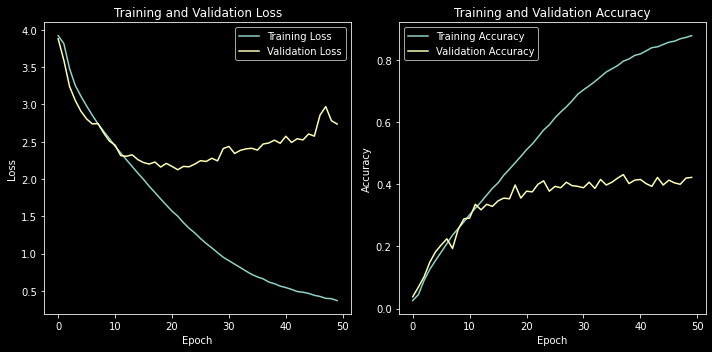

{'true_labels': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  15,
  15,
  15,
  15,
  15,
  15,
  15,
  15,
  15,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  17,
  17,
  17,
  17,
  17,
  17,
  17,
  17,
  17,
  18,
  18,
  18,
  18,
  18,
  18,
  18,
  18,
  18,
  19,
  19,
  19,
  19,
  19,
  19,
  19,
  19,
 

In [1]:
import matplotlib.pyplot as plt
import pickle
train_record = pickle.load(open('record/Q1_diff_ch_reweighted/train_record/train_record_lr0.0001_bn_dropout.pkl', 'rb'))
test_record = pickle.load(open('record/Q1_diff_ch_reweighted/test_record/test_record_lr0.0001_bn_dropout.pkl', 'rb'))
# Get the training and validation loss and accuracy
train_loss = train_record['train_loss']
train_acc = train_record['train_acc']
valid_loss = train_record['val_loss']
valid_acc = train_record['val_acc']

# Plot the training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
num_epochs = 50
plt.plot(range(num_epochs), train_loss, label='Training Loss')
plt.plot(range(num_epochs), valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_acc, label='Training Accuracy')
plt.plot(range(num_epochs), valid_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
test_record

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class CustomConv(nn.Module):
    def __init__(self, out_channels, img_size, kernel_size):
        super(CustomConv, self).__init__()

        self.linear_R = nn.Linear(img_size*img_size, 1)
        self.linear_G = nn.Linear(img_size*img_size, 1)
        self.linear_B = nn.Linear(img_size*img_size, 1)

        self.conv = nn.Conv2d(in_channels=3, out_channels=out_channels, kernel_size=kernel_size, padding=kernel_size//2)
        
    def forward(self, x, open_channels):
        batch_size, channels, height, width = x.size()
        # Flatten each channel
        x_flattened = x.view(batch_size, channels, -1)  # Shape: (batch_size, channels, height*width)
        weight_R = self.linear_R(x_flattened[:, 0, :])
        weight_G = self.linear_G(x_flattened[:, 1, :])
        weight_B = self.linear_B(x_flattened[:, 2, :])
        kernel_weight = torch.stack([weight_R, weight_G, weight_B]).permute(1, 0, 2) 
        kernel_weight = kernel_weight.masked_fill(open_channels.unsqueeze(-1) == 0, float('-inf'))
        kernel_weight = F.softmax(kernel_weight, dim=1)
        print(kernel_weight)
        out = self.conv(x*kernel_weight.unsqueeze(-1))
        return out

# class CustomConv(nn.Module):
#     def __init__(self, out_channels, img_size, kernel_size):
#         super(CustomConv, self).__init__()
#         self.conv = nn.Conv2d(in_channels=3, out_channels=out_channels, kernel_size=kernel_size, padding=kernel_size//2)
#         
#     def forward(self, x, open_channels):
#         batch_size, channels, height, width = x.size()
#         # Flatten each channel        
#         ones_count = open_channels.sum(dim=1, keepdim=True)  # Count the number of 1s in each row
#         multiplier = (open_channels.float() / ones_count.float()) * 3  # Calculate the multiplier for each row
#         multiplier = multiplier.view(multiplier.size(0), multiplier.size(1), 1, 1)  # Reshape for broadcasting
#         
#         out = self.conv(x * multiplier)
# 
#         return out

model = CustomConv(out_channels=10, img_size=28, kernel_size=3)
input = torch.randn(2, 3, 28, 28)
open_channels = torch.tensor([[0, 1, 1], [0, 1, 1]])
# 示例代码用于检查CustomConv的梯度
def check_grad_custom_conv():
    # 创建模型实例和随机输入    
    # 运行前向传播和反向传播
    output = model(input, open_channels)
    loss = output.sum()  # 示例损失函数
    loss.backward()
    
    # 打印每个参数的梯度
    print("Gradient of linear_R weight:", model.linear_R.weight.grad[0][:10])

# 调用检查梯度的函数
check_grad_custom_conv()


tensor([[[0.0000],
         [0.4626],
         [0.5374]],

        [[0.0000],
         [0.5318],
         [0.4682]]], grad_fn=<SoftmaxBackward0>)
Gradient of linear_R weight: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [11]:
check_grad_custom_conv()


tensor([[[0.0000],
         [0.4626],
         [0.5374]],

        [[0.0000],
         [0.5318],
         [0.4682]]], grad_fn=<SoftmaxBackward0>)
Gradient of linear_R weight: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


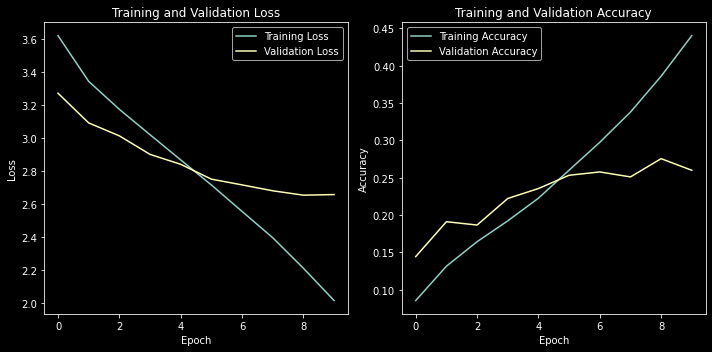

[0.26018160284247926, 0.2974654559810501, 0.33790761942360836, 0.386008685353336, 0.44031583103039873]
[0.25333333333333335, 0.2577777777777778, 0.2511111111111111, 0.27555555555555555, 0.26]


(0.2810990447461036, 0.2688888888888889, 0.2641060010867522)

In [21]:
import matplotlib.pyplot as plt
import pickle
train_record = pickle.load(open('record/Q2_less_layers/train_record/train_record_lr1e-05_bn_dropout.pkl', 'rb'))
test_record = pickle.load(open('record/Q2_less_layers/test_record/test_record_lr1e-05_bn_dropout.pkl', 'rb'))
# Get the training and validation loss and accuracy
train_loss = train_record['train_loss']
train_acc = train_record['train_acc']
valid_loss = train_record['val_loss']
valid_acc = train_record['val_acc']

# Plot the training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
num_epochs = 10
plt.plot(range(num_epochs), train_loss, label='Training Loss')
plt.plot(range(num_epochs), valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_acc, label='Training Accuracy')
plt.plot(range(num_epochs), valid_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
print(train_record['train_acc'][5:])
print(train_record['val_acc'][5:])
test_record['precision'], test_record['recall'], test_record['f1']

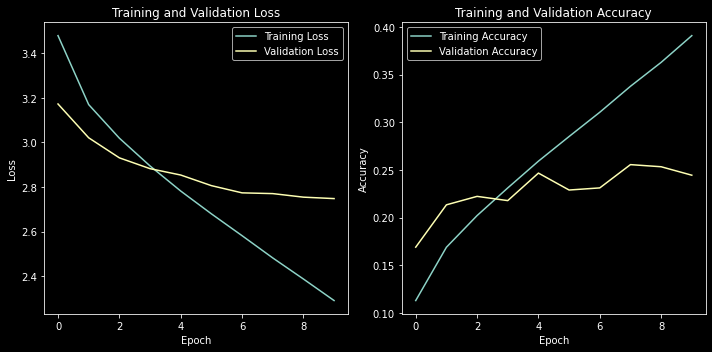

[0.28508487958941964, 0.3105408606395578, 0.3377970785629688, 0.3629214370311883, 0.39098302408211605]
[0.2288888888888889, 0.2311111111111111, 0.25555555555555554, 0.25333333333333335, 0.24444444444444444]


(0.27535217998375894, 0.28444444444444444, 0.2672345514508524)

In [22]:
import matplotlib.pyplot as plt
import pickle
train_record = pickle.load(open('record/Q2_less_layers/train_record/train_record_lr1e-06_bn_dropout.pkl', 'rb'))
test_record = pickle.load(open('record/Q2_less_layers/test_record/test_record_lr1e-06_bn_dropout.pkl', 'rb'))
# Get the training and validation loss and accuracy
train_loss = train_record['train_loss']
train_acc = train_record['train_acc']
valid_loss = train_record['val_loss']
valid_acc = train_record['val_acc']

# Plot the training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
num_epochs = 10
plt.plot(range(num_epochs), train_loss, label='Training Loss')
plt.plot(range(num_epochs), valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_acc, label='Training Accuracy')
plt.plot(range(num_epochs), valid_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
print(train_record['train_acc'][5:])
print(train_record['val_acc'][5:])
test_record['precision'], test_record['recall'], test_record['f1']

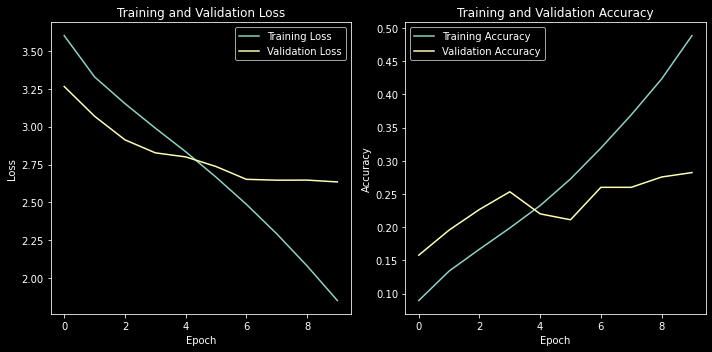

[0.2726727200947493, 0.31919463087248323, 0.36923805763916306, 0.42321358073430715, 0.4885748124753257]
[0.2111111111111111, 0.26, 0.26, 0.27555555555555555, 0.2822222222222222]


(0.28378178194354664, 0.2577777777777778, 0.2538292060880296)

In [23]:
import matplotlib.pyplot as plt
import pickle
train_record = pickle.load(open('record/Q2_less_layers/train_record/train_record_lr1e-05_bn_dropout50.pkl', 'rb'))
test_record = pickle.load(open('record/Q2_less_layers/test_record/test_record_lr1e-05_bn_dropout50.pkl', 'rb'))
# Get the training and validation loss and accuracy
train_loss = train_record['train_loss']
train_acc = train_record['train_acc']
valid_loss = train_record['val_loss']
valid_acc = train_record['val_acc']

# Plot the training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
num_epochs = 10
plt.plot(range(num_epochs), train_loss, label='Training Loss')
plt.plot(range(num_epochs), valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_acc, label='Training Accuracy')
plt.plot(range(num_epochs), valid_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
print(train_record['train_acc'][5:])
print(train_record['val_acc'][5:])
test_record['precision'], test_record['recall'], test_record['f1']

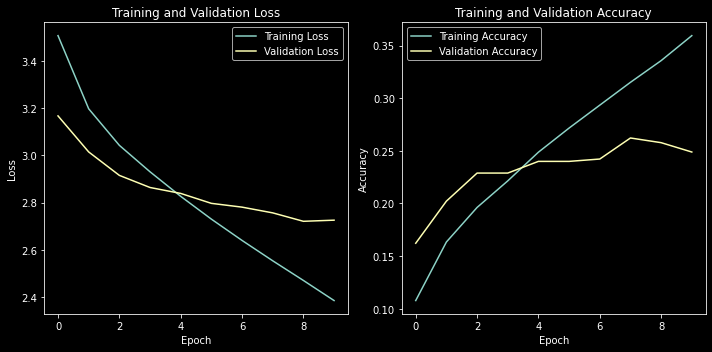

[0.27166206079747335, 0.2934228187919463, 0.3151204105803395, 0.33572838531385707, 0.35946308724832216]
[0.24, 0.24222222222222223, 0.26222222222222225, 0.2577777777777778, 0.24888888888888888]


(0.29624302878139197, 0.28, 0.262235022776772)

In [24]:
import matplotlib.pyplot as plt
import pickle
train_record = pickle.load(open('record/Q2_less_layers/train_record/train_record_lr1e-06_bn_dropout50.pkl', 'rb'))
test_record = pickle.load(open('record/Q2_less_layers/test_record/test_record_lr1e-06_bn_dropout50.pkl', 'rb'))
# Get the training and validation loss and accuracy
train_loss = train_record['train_loss']
train_acc = train_record['train_acc']
valid_loss = train_record['val_loss']
valid_acc = train_record['val_acc']

# Plot the training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
num_epochs = 10
plt.plot(range(num_epochs), train_loss, label='Training Loss')
plt.plot(range(num_epochs), valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_acc, label='Training Accuracy')
plt.plot(range(num_epochs), valid_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
print(train_record['train_acc'][5:])
print(train_record['val_acc'][5:])
test_record['precision'], test_record['recall'], test_record['f1']

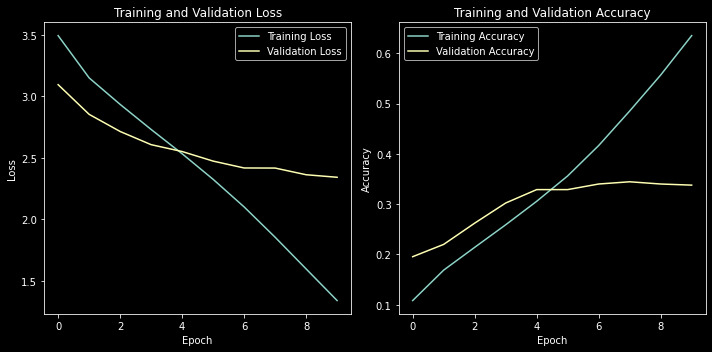

[0.10836162652980655, 0.16885906040268456, 0.21413343861034348, 0.2589498618239242, 0.3056296881168575, 0.35608369522305566, 0.4164232135807343, 0.48508487958941965, 0.5565574417686537, 0.6348835373075404]
[0.19555555555555557, 0.22, 0.26222222222222225, 0.3022222222222222, 0.3288888888888889, 0.3288888888888889, 0.34, 0.34444444444444444, 0.34, 0.3377777777777778]


(0.37970499435205324, 0.37333333333333335, 0.3620732739568653)

In [6]:
import matplotlib.pyplot as plt
import pickle
train_record = pickle.load(open('record/Q2_less_layers/train_record/train_record_lr1e-05_6layers.pkl', 'rb'))
test_record = pickle.load(open('record/Q2_less_layers/test_record/test_record_lr1e-05_6layers.pkl', 'rb'))
# Get the training and validation loss and accuracy
train_loss = train_record['train_loss']
train_acc = train_record['train_acc']
valid_loss = train_record['val_loss']
valid_acc = train_record['val_acc']

# Plot the training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
num_epochs = 10
plt.plot(range(num_epochs), train_loss, label='Training Loss')
plt.plot(range(num_epochs), valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_acc, label='Training Accuracy')
plt.plot(range(num_epochs), valid_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
print(train_record['train_acc'])
print(train_record['val_acc'])
test_record['precision'], test_record['recall'], test_record['f1']

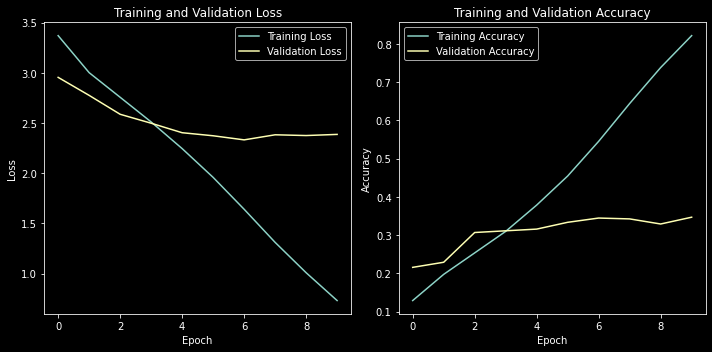

[0.12876431109356495, 0.19723647848401105, 0.25334386103434664, 0.30959336754836164, 0.37831819976312675, 0.4543229372285827, 0.5450296091590999, 0.6438689301223846, 0.7378760363205685, 0.8213028030003948]
[0.21555555555555556, 0.2288888888888889, 0.30666666666666664, 0.3111111111111111, 0.31555555555555553, 0.3333333333333333, 0.34444444444444444, 0.3422222222222222, 0.3288888888888889, 0.3466666666666667]
[3.3699071711680655, 3.001345942343265, 2.7563749495128658, 2.510671392452844, 2.245434084599356, 1.9587714490201509, 1.641339238033528, 1.3115808126778645, 1.0095623683722368, 0.7323346991168149]
[2.9545362122853596, 2.7752434004677666, 2.58701041592492, 2.4979684766133627, 2.4034217691421507, 2.3730297552214727, 2.3321826790438758, 2.382743229866028, 2.3753189714749654, 2.386636883947584]


(0.36408938773644656, 0.3511111111111111, 0.34448776757808924)

In [8]:
import matplotlib.pyplot as plt
import pickle
train_record = pickle.load(open('record/Q2_less_layers/train_record/train_record_lr1e-05_6layers_2048.pkl', 'rb'))
test_record = pickle.load(open('record/Q2_less_layers/test_record/test_record_lr1e-05_6layers_2048.pkl', 'rb'))
# Get the training and validation loss and accuracy
train_loss = train_record['train_loss']
train_acc = train_record['train_acc']
valid_loss = train_record['val_loss']
valid_acc = train_record['val_acc']

# Plot the training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
num_epochs = 10
plt.plot(range(num_epochs), train_loss, label='Training Loss')
plt.plot(range(num_epochs), valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_acc, label='Training Accuracy')
plt.plot(range(num_epochs), valid_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
print(train_record['train_acc'])
print(train_record['val_acc'])
print(train_record['train_loss'])
print(train_record['val_loss'])
test_record['precision'], test_record['recall'], test_record['f1']

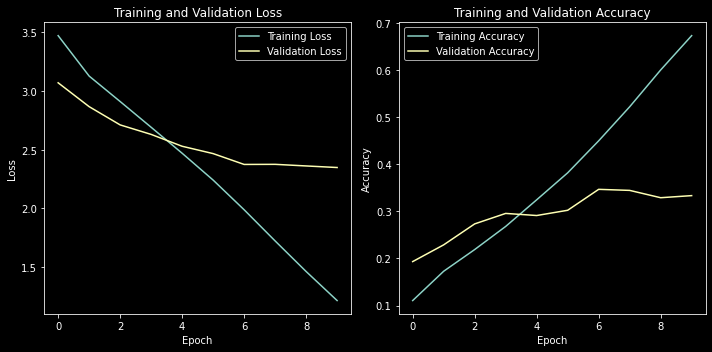

[0.11063560994867745, 0.17285432293722858, 0.21888669561784446, 0.2679510461902882, 0.32443742597710223, 0.38171338333991317, 0.4496012633241216, 0.5218476115278327, 0.60001579155152, 0.6728464271614686]
[0.19333333333333333, 0.2288888888888889, 0.2733333333333333, 0.29555555555555557, 0.2911111111111111, 0.3022222222222222, 0.3466666666666667, 0.34444444444444444, 0.3288888888888889, 0.3333333333333333]


(0.3627560495060495, 0.37333333333333335, 0.3582361576444225)

In [5]:
import matplotlib.pyplot as plt
import pickle
train_record = pickle.load(open('record/Q2_less_layers/train_record/train_record_lr1e-05_6layers_dropout50.pkl', 'rb'))
test_record = pickle.load(open('record/Q2_less_layers/test_record/test_record_lr1e-05_6layers_dropout50.pkl', 'rb'))
# Get the training and validation loss and accuracy
train_loss = train_record['train_loss']
train_acc = train_record['train_acc']
valid_loss = train_record['val_loss']
valid_acc = train_record['val_acc']

# Plot the training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
num_epochs = 10
plt.plot(range(num_epochs), train_loss, label='Training Loss')
plt.plot(range(num_epochs), valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_acc, label='Training Accuracy')
plt.plot(range(num_epochs), valid_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
print(train_record['train_acc'])
print(train_record['val_acc'])
test_record['precision'], test_record['recall'], test_record['f1']